In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from termcolor import colored
import random
import warnings
warnings.filterwarnings("ignore")

import empyrical

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['figure.figsize'] = (8, 6)  

def report(tradelist,initial_capital,type_analisy,Benchmark):
    
    %matplotlib inline
    import quantstats as qs
    qs.extend_pandas()

    tradelist = tradelist.fillna(0)
    tradelist = tradelist[tradelist!=0]
    tradelist.iloc[0] = tradelist.iloc[0]+initial_capital
    tradelist = tradelist.cumsum()

    if type_analisy == 0:
        qs.plots.snapshot(tradelist)

    if type_analisy == 1:    
        if len(Benchmark)==0:
            qs.reports.basic(tradelist)
        else:
            qs.reports.basic(tradelist,Benchmark)

    if type_analisy == 2:    
        if len(Benchmark)==0:
            qs.reports.full(tradelist)
        else:
            qs.reports.full(tradelist,Benchmark)

In [2]:
def readdata_MT5_Date(market,tf,path,start,stop):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd
    
    while True:

        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        mk=str(market)
        TF="mt5.TIMEFRAME_"+str(tf)

        start_y , start_m , start_d = start.split("-")
        stop_y , stop_m , stop_d = stop.split("-")
        
        utc_from = datetime(int(start_y), int(start_m), int(start_d))
        utc_to = datetime(int(stop_y), int(stop_m), int(stop_d))
        
        rates = mt5.copy_rates_range(mk, eval(TF), utc_from, utc_to) 
    

        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume","spread"]]
        rates_frame.columns=(["time","open","high","low","close","volume","spread"])
        rates_frame=rates_frame.set_index(["time"])

        if rates_frame is not None:
            return rates_frame
            break

def get_poin_value(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return round(tmp)

            
def get_tick_value(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['trade_tick_size']

In [3]:
path=(r"C:\Program Files\AMP Global (USA) MT5 Exchange-Traded Futures Only\terminal64.exe")
path=(r"C:\Program Files\AMP Global (EU) MT5 Terminal 1\terminal64.exe")

In [4]:
def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

all_symbol = allsymbols(path)
[e for e in all_symbol if ("X" in e)&(len(e)==6)&("USD" in e)]

['USDMXN',
 'XAGUSD',
 'XAUUSD',
 'XPDUSD',
 'XPTUSD',
 'XBRUSD',
 'XNGUSD',
 'XTIUSD',
 'XRPUSD',
 'XLMUSD',
 'XTZUSD',
 'AVXUSD']

In [18]:
mt5_simboli=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD","CADCHF","CADJPY","CHFJPY","EURAUD","EURCAD","EURCHF","EURGBP","EURJPY","EURNZD","EURUSD" ,"GBPAUD","GBPCAD","GBPCHF","GBPJPY","GBPNZD","GBPUSD","NZDCAD","NZDCHF","NZDJPY","NZDUSD","USDCAD",\
            "USDCHF","USDJPY"]

#mt5_simboli = [e for e in mt5_simboli if "JPY" in e]
"""mt5_simboli=["EURAUD","EURCAD","EURCHF","EURGBP","EURJPY","EURNZD","EURUSD"] 

mt5_simboli=['XAGUSD',
 'XAUUSD',
 'XPDUSD',
 'XPTUSD',
 'XBRUSD',
 'XNGUSD',
 'XTIUSD']
"""
data = pd.DataFrame()

for e in tqdm(mt5_simboli):
    df = readdata_MT5_Date(e,"D1",path,"2016-01-01","2024-05-01")
    bpv = get_poin_value(path,e)
    df["bigpointvalue"] = get_poin_value(path,e)
    df["tick"] = get_tick_value(path,e)
    df["costi"] = costi = (df.spread.mean() * df.tick) * df.bigpointvalue
    multiindex = pd.MultiIndex.from_product([[e], df.columns], names=['Symbol', 'Original_Column'])
    df.columns = multiindex
    data = pd.concat([data,df],axis=1).ffill()
    
data = data.fillna(0)   
data.tail()

  0%|          | 0/28 [00:00<?, ?it/s]

Symbol            AUDCAD                                             \
Original_Column     open     high      low    close   volume spread   
time                                                                  
2024-02-20       0.88187  0.88898  0.88088  0.88554  48880.0    0.0   
2024-02-21       0.88533  0.88771  0.88296  0.88485  49758.0    0.0   
2024-02-22       0.88418  0.88665  0.88291  0.88391  52084.0    0.0   
2024-02-23       0.88351  0.88673  0.88292  0.88630  45222.0    0.0   
2024-02-26       0.88545  0.88696  0.88319  0.88342  29422.0    0.0   

Symbol                                             AUDCHF  ...    USDCHF  \
Original_Column bigpointvalue     tick     costi     open  ...     costi   
time                                                       ...             
2024-02-20            68245.0  0.00001  5.124667  0.57579  ...  2.054853   
2024-02-21            68245.0  0.00001  5.124667  0.57741  ...  2.054853   
2024-02-22            68245.0  0.00001  5.124667  0.57588  ...  2.054853   
2024-02-23            68245.0  0.00001  5.124667  0.57649  ...  2.054853   
2024-02-26            68245.0  0.00001  5.124667  0.57715  ...  2.054853   

Symbol            USDJPY                                             \
Original_Column     open     high      low    close   volume spread   
time                                                                  
2024-02-20       150.064  150.440  149.687  149.993  81215.0    0.0   
2024-02-21       149.880  150.392  149.855  150.284  76429.0    0.0   
2024-02-22       150.280  150.691  150.018  150.535  90334.0    0.0   
2024-02-23       150.513  150.771  150.295  150.538  80038.0    0.0   
2024-02-26       150.487  150.749  150.292  150.716  55758.0    0.0   

Symbol                                          
Original_Column bigpointvalue   tick     costi  
time                                            
2024-02-20              612.0  0.001  1.173362  
2024-02-21              612.0  0.001  1.173362  
2024-02-22              612.0  0.001  1.173362  
2024-02-23              612.0  0.001  1.173362  
2024-02-26              612.0  0.001  1.173362  

[5 rows x 252 columns]

  0%|          | 0/28 [00:00<?, ?it/s]

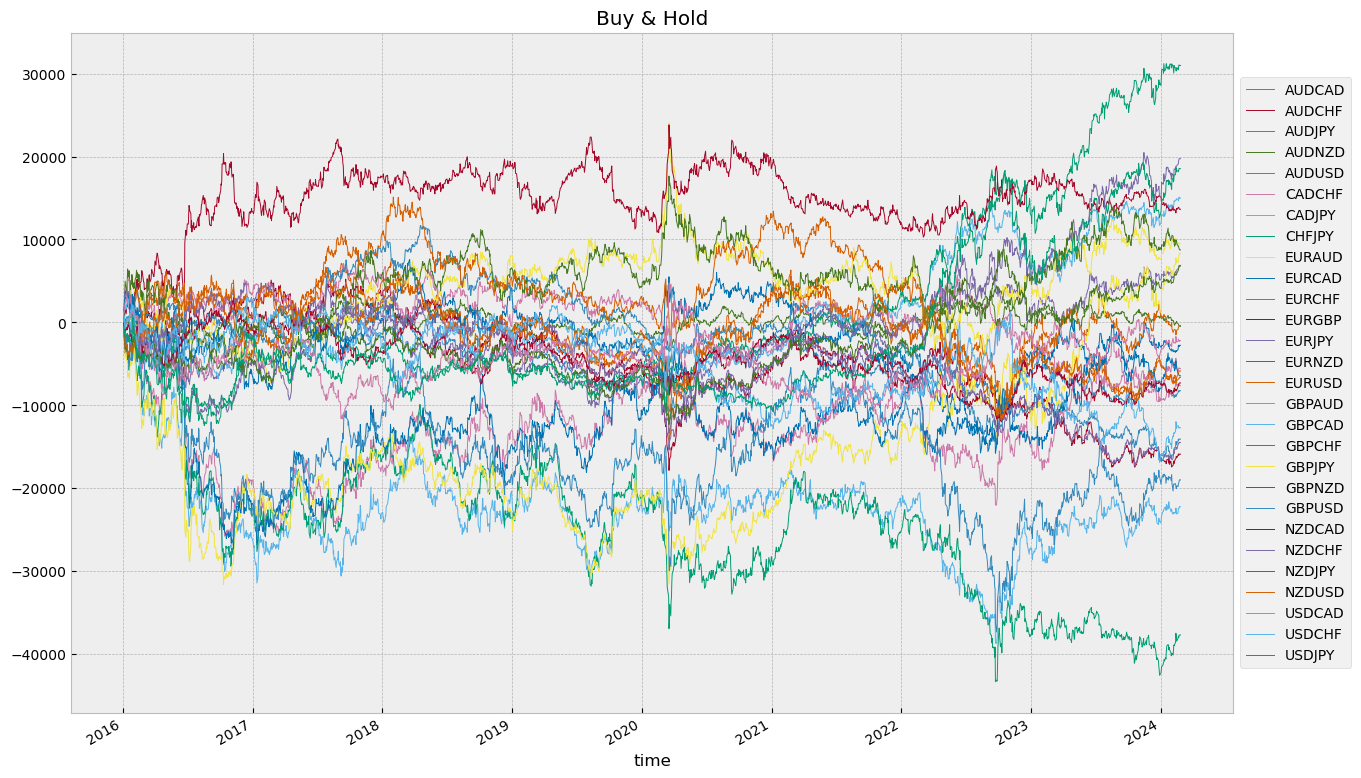

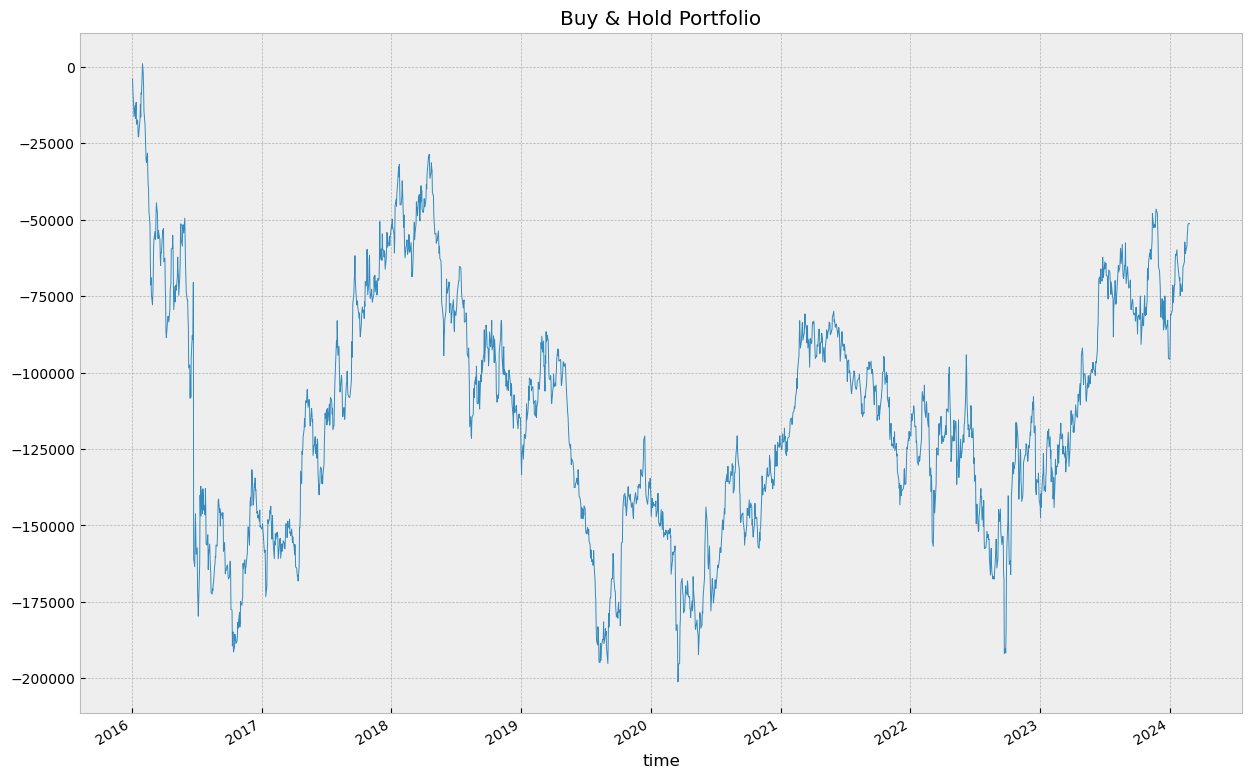

In [19]:
pnl = pd.DataFrame()

asset_list = data.columns.get_level_values(0).unique().tolist()

for asset in tqdm(asset_list):
    
    df = data.loc[:, asset]
    buy_and_hold = ((df.open.shift(-1)-df.open)*df.bigpointvalue).to_frame(asset)
    #buy_and_hold = -buy_and_hold 
    #buy_and_hold = ((df.open-df.open.shift(1))*df.bigpointvalue).to_frame(asset)
    
    #buy_and_hold[buy_and_hold.index.hour==22] = 0
    #buy_and_hold[buy_and_hold.index.hour==0] = 0
    
    pnl = pd.concat([pnl,buy_and_hold],axis=1)
    
pnl=pnl.fillna(0)
pnl.cumsum().plot(figsize=(15,10) ,title="Buy & Hold")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

pnl.sum(axis=1).cumsum().plot(figsize=(15,10) ,title="Buy & Hold Portfolio")
plt.show()

In [20]:
norm = pnl.std().to_frame("dev_std")
norm["std_max"] = norm.dev_std.max()
norm["Size"] = (norm["std_max"]/norm["dev_std"])#.astype(int)
norm

,dev_std,std_max,Size
AUDCAD,291.591026,747.245949,2.562651
AUDCHF,416.234172,747.245949,1.795254
AUDJPY,367.483909,747.245949,2.033411
AUDNZD,220.939913,747.245949,3.382123
AUDUSD,415.815946,747.245949,1.797059
CADCHF,391.471906,747.245949,1.908811
CADJPY,369.816057,747.245949,2.020588
CHFJPY,399.953303,747.245949,1.868333
EURAUD,497.696344,747.245949,1.501409
EURCAD,483.584336,747.245949,1.545224


In [21]:
for asset in tqdm(pnl.columns):
    size = int(norm.Size[norm.index==asset])
    pnl[asset] = pnl[asset] * size

  0%|          | 0/28 [00:00<?, ?it/s]

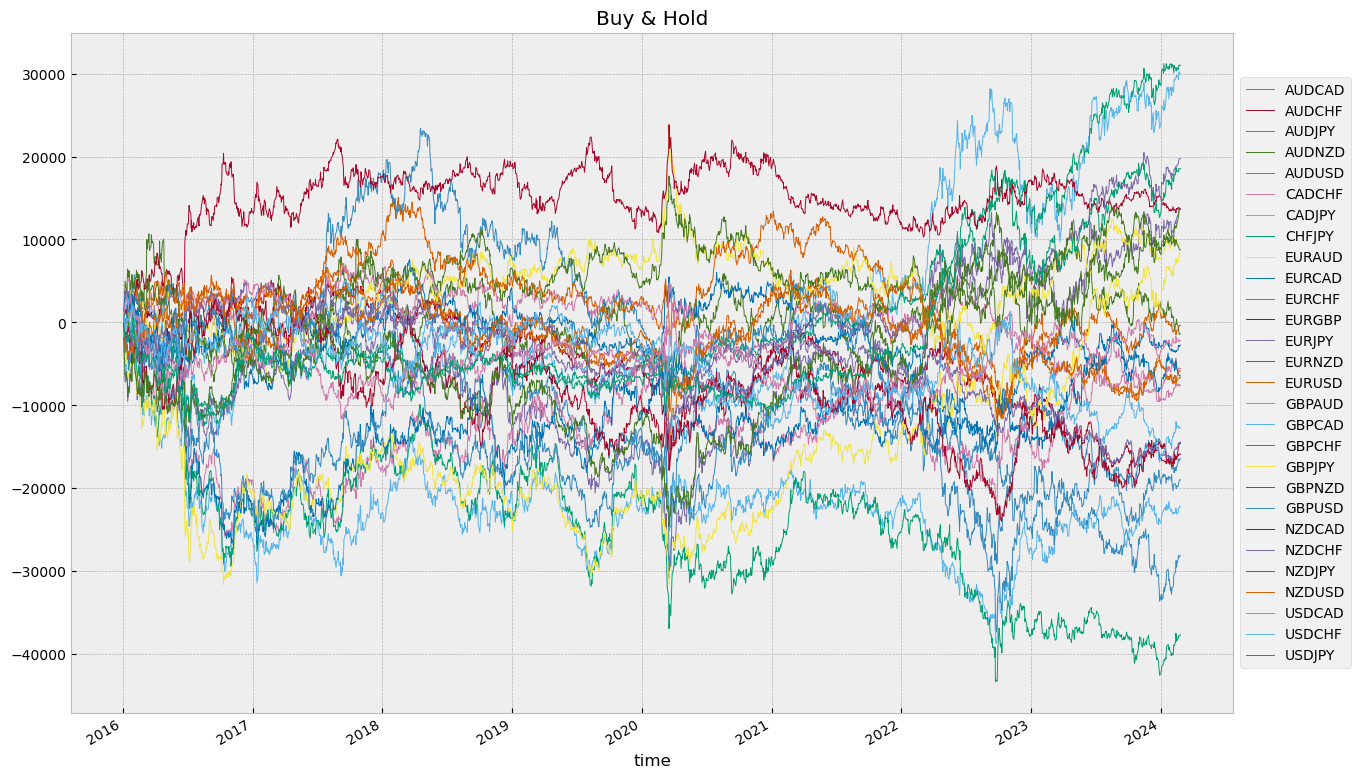

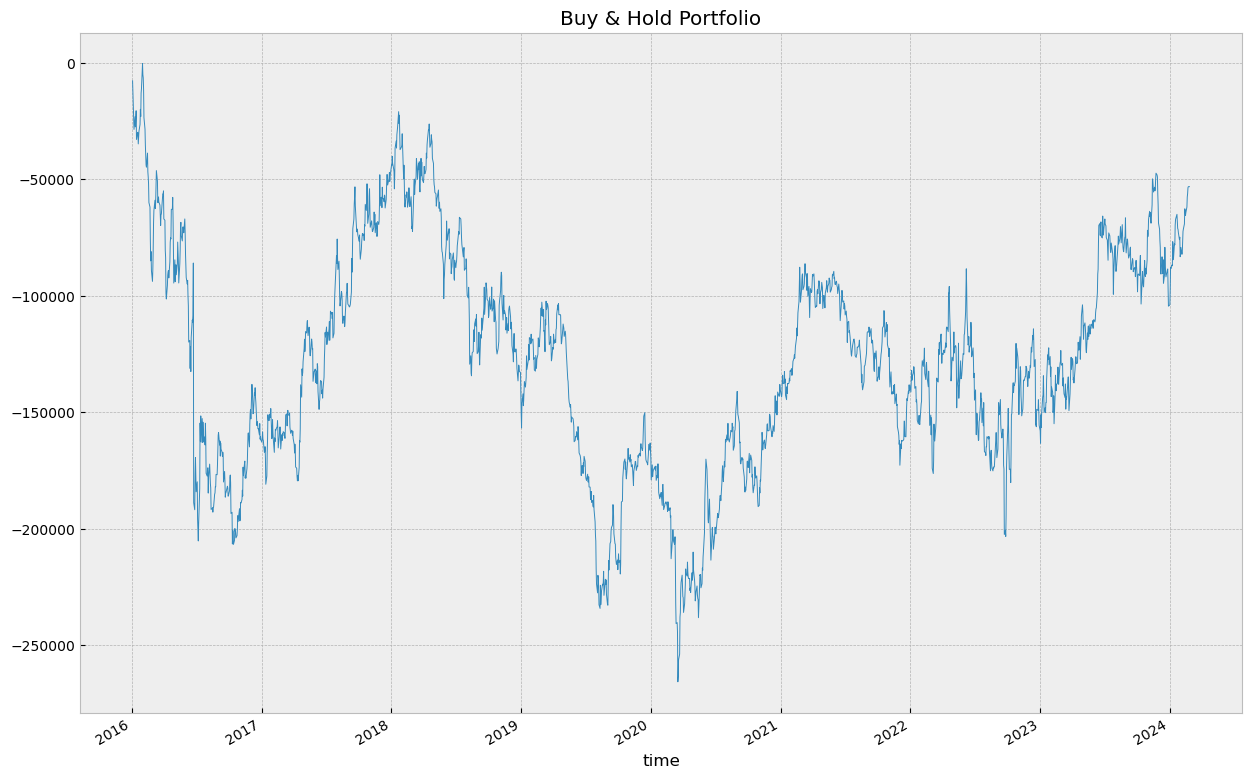

In [22]:
pnl.cumsum().plot(figsize=(15,10) ,title="Buy & Hold")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

pnl.sum(axis=1).cumsum().plot(figsize=(15,10) ,title="Buy & Hold Portfolio")
plt.show()

In [23]:
def preprocess(dataset):
    
    dataset_perc = dataset.apply(lambda x: np.log(x)).pct_change()
    
    LPERC = 0.01
    HPERC = 0.99

    for column in dataset_perc.columns:
        lower_perc = dataset_perc[column].quantile(LPERC)
        higher_perc = dataset_perc[column].quantile(HPERC)
        dataset_perc[column] = dataset_perc[column].clip(lower_perc,higher_perc)
        
    dataset_perc["avgclose5"] = dataset_perc.close.rolling(5).mean()
    dataset_perc["avgclose20"] = dataset_perc.close.rolling(20).mean()
    dataset_perc["avgclose50"] = dataset_perc.close.rolling(50).mean()
    dataset_perc["avgclose100"] = dataset_perc.close.rolling(100).mean()
    dataset_perc["avgclose200"] = dataset_perc.close.rolling(200).mean()

    dataset_perc["stdclose5"] = dataset_perc.close.rolling(5).std()
    dataset_perc["stdclose20"] = dataset_perc.close.rolling(20).std()
    dataset_perc["stdclose50"] = dataset_perc.close.rolling(50).std()
    dataset_perc["stdclose100"] = dataset_perc.close.rolling(100).std()
    dataset_perc["stdclose200"] = dataset_perc.close.rolling(200).std()

    dataset_perc["max5"] = dataset_perc.high.rolling(5).max()
    dataset_perc["max20"] = dataset_perc.high.rolling(20).max()
    dataset_perc["max50"] = dataset_perc.high.rolling(50).max()
    dataset_perc["max100"] = dataset_perc.high.rolling(100).max()
    dataset_perc["max200"] = dataset_perc.high.rolling(200).max()

    dataset_perc["min5"] = dataset_perc.low.rolling(5).min()
    dataset_perc["min20"] = dataset_perc.low.rolling(20).min()
    dataset_perc["min50"] = dataset_perc.low.rolling(50).min()
    dataset_perc["min100"] = dataset_perc.low.rolling(100).min()
    dataset_perc["min200"] = dataset_perc.low.rolling(200).min()
        
    """dataset_perc["sharpe_ratio5"] = dataset_perc.close.rolling(5).apply(empyrical.sharpe_ratio)    
    dataset_perc["sharpe_ratio20"] = dataset_perc.close.rolling(20).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio50"] = dataset_perc.close.rolling(50).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio100"] = dataset_perc.close.rolling(100).apply(empyrical.sharpe_ratio)
    dataset_perc["sharpe_ratio200"] = dataset_perc.close.rolling(200).apply(empyrical.sharpe_ratio)
    
    dataset_perc["omega_ratio5"] = dataset_perc.close.rolling(5).apply(empyrical.omega_ratio)    
    dataset_perc["omega_ratio20"] = dataset_perc.close.rolling(20).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio50"] = dataset_perc.close.rolling(50).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio100"] = dataset_perc.close.rolling(100).apply(empyrical.omega_ratio)
    dataset_perc["omega_ratio200"] = dataset_perc.close.rolling(200).apply(empyrical.omega_ratio)
    
    dataset_perc["sortino_ratio5"] = dataset_perc.close.rolling(5).apply(empyrical.sortino_ratio)    
    dataset_perc["sortino_ratio20"] = dataset_perc.close.rolling(20).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio50"] = dataset_perc.close.rolling(50).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio100"] = dataset_perc.close.rolling(100).apply(empyrical.sortino_ratio)
    dataset_perc["sortino_ratio200"] = dataset_perc.close.rolling(200).apply(empyrical.sortino_ratio)"""
    
                
    df_temp = pd.DataFrame()
    shift_range = 5
    
    ls_avg = ["avgclose5","avgclose20","avgclose50","avgclose100","avgclose200"]  
    ls_std = ["stdclose5","stdclose20","stdclose50","stdclose100","stdclose200"]
    ls_max = ["max5","max20","max50","max100","max200"]
    ls_min = ["min5","min20","min50","min100","min200"]
    ls_sharpe = ["sharpe_ratio5","sharpe_ratio20","sharpe_ratio50","sharpe_ratio100","sharpe_ratio200"]
    ls_sortino = ["sortino_ratio5","sortino_ratio20","sortino_ratio50","sortino_ratio100","sortino_ratio200"] 
    ls_omega = ["omega_ratio5","omega_ratio20","omega_ratio50","omega_ratio100","omega_ratio200"] 
    
    ls_full = [ls_avg,ls_std,ls_max,ls_min]# ,ls_sharpe,ls_sortino,ls_omega]
    
    for ls_t in ls_full:
        for I in ls_t:
            for O in ls_t:        
                for t1 in range(1,shift_range+1):
                    for t2 in range(1,shift_range+1):
                        if t1 != t2:
                            df_temp[I+".shift("+str(t1)+")>"+O+".shift("+str(t2)+")"] = dataset_perc[I].shift(t1)>dataset_perc[O].shift(t2)               
                                                                        
    return df_temp

In [24]:
array_list=[]

for asset in tqdm(asset_list):
    
    df = data.loc[:, asset]
    
    df_t = preprocess(df)
    
    df_t = df_t[df_t.index.isin(pnl.index)]
    
    array_list.append(df_t.T.to_numpy())
    
array_pnl = pnl.T.to_numpy()  

array_list = np.stack(array_list) 

array_rules = df_t.columns.to_numpy()

  0%|          | 0/28 [00:00<?, ?it/s]

In [25]:
def get_dna(individual, array_rules):
    
    dna = array_rules[individual[0]]

    for ind in individual[1:]:
        dna = dna + " & " + array_rules[ind]

    return dna

def create_dna(individual, array_list):
    
    dna = array_list[:, individual[0], :]

    for ind in individual[1:]:
        dna = np.bitwise_and(dna, array_list[:, ind, :])

    return dna

def my_instability(array,pct):
    
    n_element = int(pct * len(array))

    array_ = array.copy()

    indici_ = np.random.choice(len(array), n_element, replace=False)

    array_[indici_] = 0

    return array_

def fitness_function(individual):

    res = create_dna(individual , array_list)
    res = res * array_pnl
    res = res.sum(axis=0)
    OOS = 1-OOS_PCT
    OOS = int(len(res)*OOS)
    res = res[:OOS]
    res = res[res!=0]
    
    if INSTABILITY != 0 :
        
        res = my_instability(res,INSTABILITY)

    rank = eval("empyrical."+FITNESS+"(res)") 
 
    if (np.isnan(rank)) | (len(res)<MIN_OPERATIONS):
        return -999999,
    else:
        return rank,
    
def engine(individual , lag):
    
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['lines.linewidth'] = 0.7
    plt.rcParams['figure.figsize'] = (8, 6)  
    
    res = create_dna(individual , array_list)
    
    if lag != 0:
        res = np.roll(res,lag)
    
    res = res * array_pnl

    results = pd.DataFrame(res).T
    results.columns = pnl.columns
    results.index = pnl.index
    
    OOS = 1-OOS_PCT
    OOS = int(len(results)*OOS)
    OOS = results.iloc[:OOS].index[-1]
    
    results.cumsum().plot(title="Portfolio Assets")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.axvline(x=OOS ,color = "red" )
    plt.show()

    results.sum(axis=1).cumsum().plot(label="Genetic Evolution")
    plt.legend(loc="upper left")
    pnl.sum(axis=1).cumsum().plot(label="Buy & Hold" ,secondary_y=True ,color="grey",linewidth=0.2)
    plt.legend(loc="lower right")
    plt.axvline(x=OOS ,color = "red" )
    plt.show()
    
    return results

In [13]:
import ray

ray.init()

2024-02-26 16:00:05,999	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.8.18
Ray version:,2.9.2


In [26]:
@ray.remote
def GAM (DNA_SIZE , CROSS_DNA_RATIO , MUTATION_PROB , POPULATION_SIZE , NUM_GENERATIONS , HALL_OF_FAME , TOURNSIZE ,
         MIN_OPERATIONS , FITNESS , INSTABILITY , ALGORITHM ):
    
    import empyrical
    
    array_list = ray.get(array_list_ray)
    array_pnl = ray.get(array_pnl_ray)
    
    def create_dna(individual, array_list):
    
        dna = array_list[:, individual[0], :]

        for ind in individual[1:]:
            dna = np.bitwise_and(dna, array_list[:, ind, :])

        return dna
    
    def my_instability(array,pct):
    
        n_element = int(pct * len(array))

        array_ = array.copy()

        indici_ = np.random.choice(len(array), n_element, replace=False)

        array_[indici_] = 0

        return array_

    def fitness_function(individual):

        res = create_dna(individual , array_list)
        res = res * array_pnl
        res = res.sum(axis=0)
        OOS = 1-OOS_PCT
        OOS = int(len(res)*OOS)
        res = res[:OOS]
        res = res[res!=0]

        if INSTABILITY != 0 :

            res = my_instability(res,INSTABILITY)

        rank = empyrical.sharpe_ratio(res) #eval("empyrical."+FITNESS+"(res)") 

        if (np.isnan(rank)) | (len(res)<MIN_OPERATIONS):
            return -999999,
        else:
            return rank,

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", fitness_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(array_rules)- 1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
    toolbox.register("individual", creator.Individual, [random.randint(0, len(array_rules)-1) for _ in range(DNA_SIZE)])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    population = toolbox.population(n=POPULATION_SIZE)

    halloffame = tools.HallOfFame(HALL_OF_FAME)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    if ALGORITHM == "eaSimple" :
        
        population, logbook = algorithms.eaSimple(population, toolbox, 
                                              cxpb=CROSS_DNA_RATIO, mutpb=MUTATION_PROB, 
                                              ngen=NUM_GENERATIONS, stats=None, 
                                              halloffame=halloffame, verbose=False)
    
    if ALGORITHM == "eaMuPlusLambda" :
        
        population, logbook = algorithms.eaMuPlusLambda(population, toolbox,
                                                   mu=len(population)//2, lambda_=len(population),
                                                   cxpb=CROSS_DNA_RATIO, mutpb=MUTATION_PROB,
                                                   ngen=NUM_GENERATIONS, stats=stats,
                                                   halloffame=halloffame, verbose=True)
    
    if ALGORITHM == "eaMuCommaLambda" :
        
        population, logbook = algorithms.eaMuCommaLambda(population, toolbox,
                                                   mu=len(population)//2, lambda_=len(population),
                                                   cxpb=CROSS_DNA_RATIO, mutpb=MUTATION_PROB,
                                                   ngen=NUM_GENERATIONS, stats=None,
                                                   halloffame=halloffame, verbose=False)

    best_solution = halloffame[0]
    #print("")
    #print(colored("Best Solution:", 'red'))
    #print(colored(get_dna(best_solution,array_rules), 'green'))
    
    return best_solution

In [47]:
from deap import base, creator, tools, algorithms
import random
random.seed(None)

DNA_SIZE = 4

CROSS_DNA_RATIO = 0.7

MUTATION_PROB = 0.3

POPULATION_SIZE = 500

NUM_GENERATIONS = 20

HALL_OF_FAME = 10

TOURNSIZE = 10

MIN_OPERATIONS = 1000

OOS_PCT = 0.1

FITNESS = "sharpe_ratio"  
# "sharpe_ratio" 
# "omega_ratio" 
# "sortino_ratio"

ALGORITHM = "eaSimple"
# eaSimple
# eaMuPlusLambda
# eaMuCommaLambda

INSTABILITY = 0.1


In [51]:
%%time

array_list_ray = ray.put(array_list)
array_pnl_ray = ray.put(array_pnl)

result_ids_full = []
for t in tqdm(range(10)):
    result_ids = []
    for strategy in range(60):
        result_ids.append(GAM.remote(DNA_SIZE , CROSS_DNA_RATIO , MUTATION_PROB , POPULATION_SIZE , NUM_GENERATIONS , HALL_OF_FAME , TOURNSIZE ,
         MIN_OPERATIONS , FITNESS , INSTABILITY , ALGORITHM ))
    
    results = ray.get(result_ids)
    result_ids_full.extend(results)
results=result_ids_full
print(len(results))

  0%|          | 0/10 [00:00<?, ?it/s]

(GAM pid=23876) C:\Users\Drako\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
(GAM pid=23876)   warnings.warn("A class named '{0}' has already been created and it "
(GAM pid=23876) C:\Users\Drako\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
(GAM pid=23876)   warnings.warn("A class named '{0}' has already been created and it "


600
CPU times: total: 1.72 s
Wall time: 46.2 s


In [58]:
600*28

16800

  0%|          | 0/600 [00:00<?, ?it/s]

<Axes: xlabel='time'>

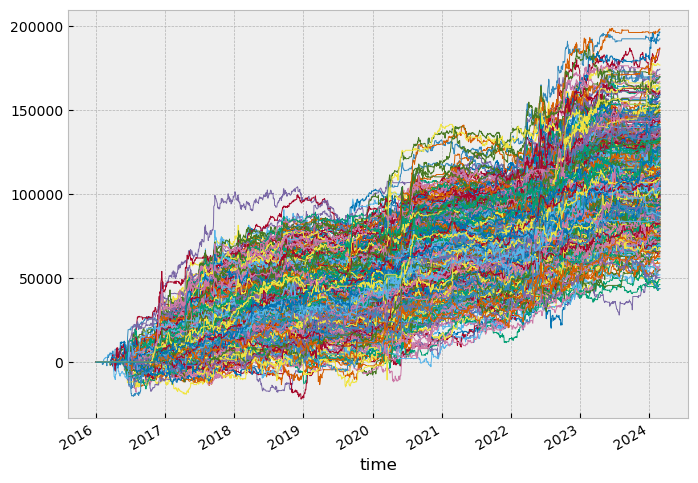

In [52]:
def engine_bt(individual , lag):
    
    res = create_dna(individual , array_list)
    
    if lag != 0:
        res = np.roll(res,lag)
    
    res = res * array_pnl

    results = pd.DataFrame(res).T
    results.columns = pnl.columns
    results.index = pnl.index
    
    return results

df_results = pd.DataFrame()
for best_solution in tqdm(results):
    tradelist = engine_bt(best_solution , 0) 
    df_results = pd.concat([df_results,tradelist.sum(axis=1).to_frame(str(best_solution))],axis=1).fillna(0)
df_results.cumsum().plot(legend=None)

In [53]:
norm = df_results.std().to_frame("dev_std")
norm["std_max"] = norm.dev_std.max()
norm["Size"] = (norm["std_max"]/norm["dev_std"])#.astype(int)
norm

,dev_std,std_max,Size
"[23, 466, 575, 310]",876.432230,1266.533444,1.445101
"[377, 153, 1339, 562]",688.442807,1266.533444,1.839708
"[946, 634, 156, 332]",641.720708,1266.533444,1.973652
"[632, 983, 435, 1541]",879.112984,1266.533444,1.440695
"[377, 1685, 38, 6]",728.386401,1266.533444,1.738821
...,...,...,...
"[917, 391, 155, 264]",866.921673,1266.533444,1.460955
"[338, 1335, 1006, 760]",844.358556,1266.533444,1.499995
"[185, 86, 832, 377]",761.697392,1266.533444,1.662778
"[840, 749, 888, 984]",680.816968,1266.533444,1.860314


In [54]:
normalize_data = df_results.copy()

for asset in tqdm(normalize_data.columns):
    size = int(norm.Size[norm.index==asset])
    normalize_data[asset] = normalize_data[asset] * size


  0%|          | 0/600 [00:00<?, ?it/s]

In [55]:
import random
import empyrical
from termcolor import colored
from deap import base, creator, tools, algorithms

N_ASSET = 10

CROSS_DNA_RATIO = 0.7

MUTATION_PROB = 0.3

POPULATION_SIZE = 500

NUM_GENERATIONS = 20

HALL_OF_FAME = 10

TOURNSIZE = 10

def evaluate(individual):

    individual = np.unique(individual)
    
    selected_data = normalize_data.iloc[:,individual].loc[:"2024-01-01"]
    
    profit = empyrical.sortino_ratio(selected_data.sum(axis=1))

    return profit,


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=normalize_data.shape[1] - 1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("individual", creator.Individual, [random.randint(0, normalize_data.shape[1]-1) for _ in range(N_ASSET)])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

population = toolbox.population(n=POPULATION_SIZE)

halloffame = tools.HallOfFame(HALL_OF_FAME)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

population, logbook = algorithms.eaSimple(population, toolbox, 
                                              cxpb=CROSS_DNA_RATIO, mutpb=MUTATION_PROB, 
                                              ngen=NUM_GENERATIONS, stats=stats, 
                                              halloffame=halloffame, verbose=True)

best_solution = halloffame[0]
print("")
print(colored("Best Solution:", 'red'))
print(colored(normalize_data.iloc[:,best_solution].columns, 'green'))


gen	nevals	avg    	min    	max    
0  	500   	3.72395	3.72395	3.72395
1  	378   	3.70929	3.18422	4.25114
2  	408   	3.79218	3.24379	4.34191
3  	385   	4.02213	2.98907	4.53254
4  	396   	4.24271	3.39985	4.90501
5  	400   	4.45408	3.41071	5.08074
6  	391   	4.67356	3.66669	5.31662
7  	390   	4.85822	3.84832	5.31837
8  	389   	5.01504	3.79925	5.47688
9  	405   	5.16018	3.93286	5.60275
10 	397   	5.26017	4.11422	5.68046
11 	400   	5.32092	3.88324	5.68046
12 	415   	5.36263	3.96363	5.69943
13 	375   	5.45962	4.09944	5.72264
14 	398   	5.50173	4.05557	5.85598
15 	391   	5.54969	4.26424	5.85598
16 	395   	5.57357	4.02727	5.85598
17 	401   	5.62064	3.78905	5.85598
18 	419   	5.65042	3.86654	5.90183
19 	387   	5.6846 	3.98664	5.93504
20 	399   	5.69536	4.5097 	5.93504

Best Solution:
Index(['[658, 692, 181, 453]', '[253, 81, 880, 719]', '[255, 942, 539, 178]',
       '[127, 508, 790, 423]', '[110, 133, 1132, 102]',
       '[377, 1653, 1359, 186]', '[717, 885, 253, 80]',
       '[1136, 117, 1549

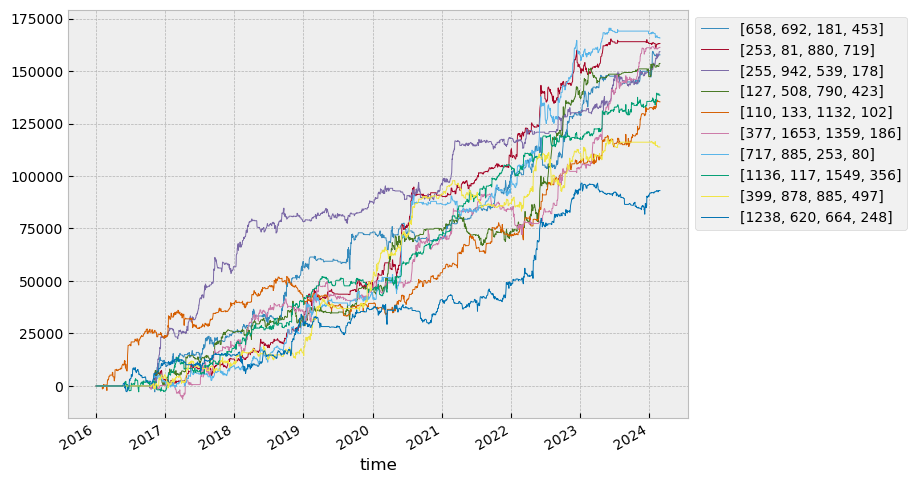

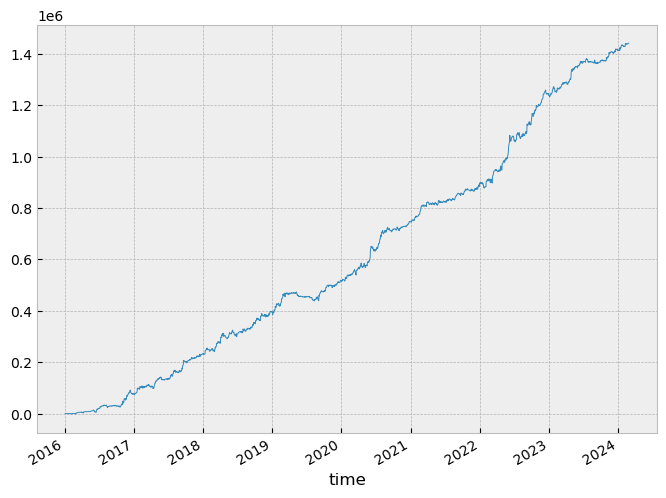

In [56]:
normalize_data.iloc[:,best_solution].cumsum().plot()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
normalize_data.iloc[:,best_solution].sum(axis=1).cumsum().plot()
plt.show()

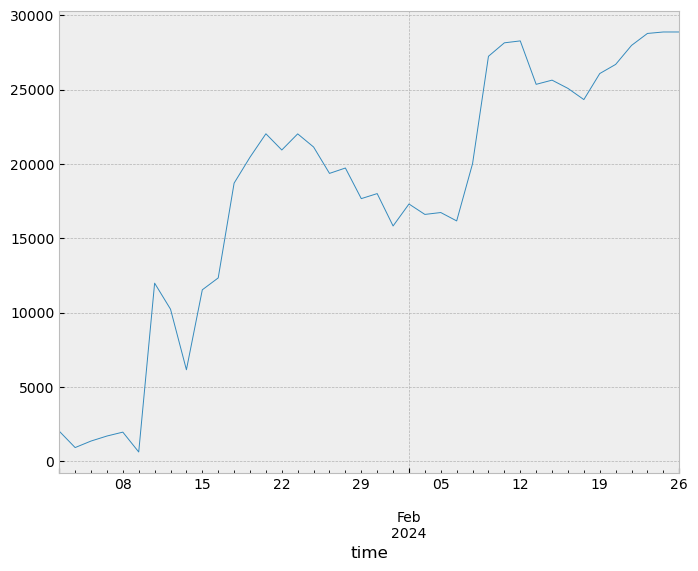

In [57]:
normalize_data.loc["2024-01-01":].iloc[:,best_solution].sum(axis=1).cumsum().plot()
plt.show()

In [29]:
normalize_data.iloc[:,best_solution].tail()

,"[398, 1376, 609, 274]","[419, 1515, 1501, 1649]","[1631, 877, 552, 269]","[776, 110, 492, 851]","[872, 579, 1622, 1631]"
time,,,,,
2024-02-23 08:00:00,0.0,0.0,0.0,0.0,0.0
2024-02-23 09:00:00,0.0,0.0,0.0,0.0,0.0
2024-02-23 10:00:00,0.0,0.0,0.0,0.0,0.0
2024-02-23 11:00:00,0.0,0.0,0.0,0.0,0.0
2024-02-23 12:00:00,0.0,0.0,0.0,0.0,0.0


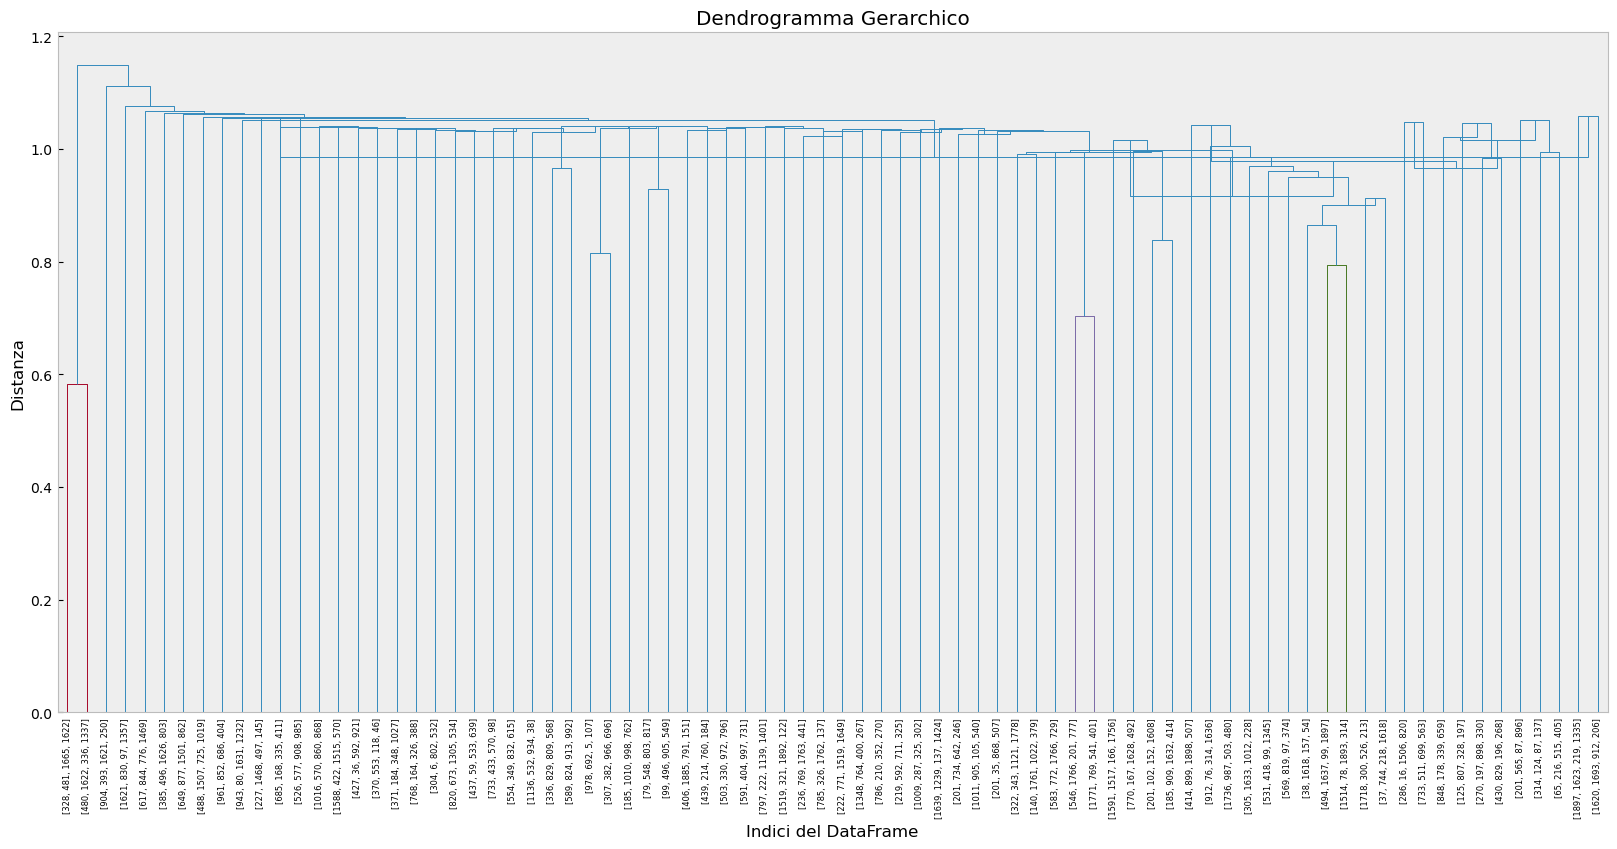

In [137]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
%matplotlib inline

num_clusters = 10  

data = normalize_data.corr().copy()

linkage_matrix = linkage(data, method='centroid')  

plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix , labels=data.columns ,leaf_rotation=90)
plt.title('Dendrogramma Gerarchico')
plt.xlabel('Indici del DataFrame')
plt.ylabel('Distanza')
plt.grid(False)
plt.subplots_adjust(bottom=0.2)
plt.show()


labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')


data['Cluster'] = labels

final_ls=[]
for e in list(set(data['Cluster'])):
    sel = data[data['Cluster']==e].iloc[:,:-1].sum(axis=1).idxmin()
    final_ls.append(sel)

In [138]:
data['Cluster'] = labels

final_ls=[]
for e in list(set(data['Cluster'])):
    sel = data[data['Cluster']==e].iloc[:,:-1].sum(axis=1).idxmin()
    final_ls.append(sel)

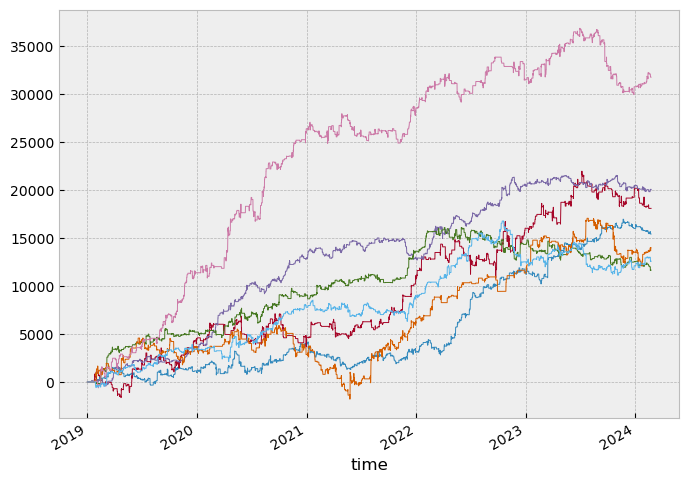

<Axes: xlabel='time'>

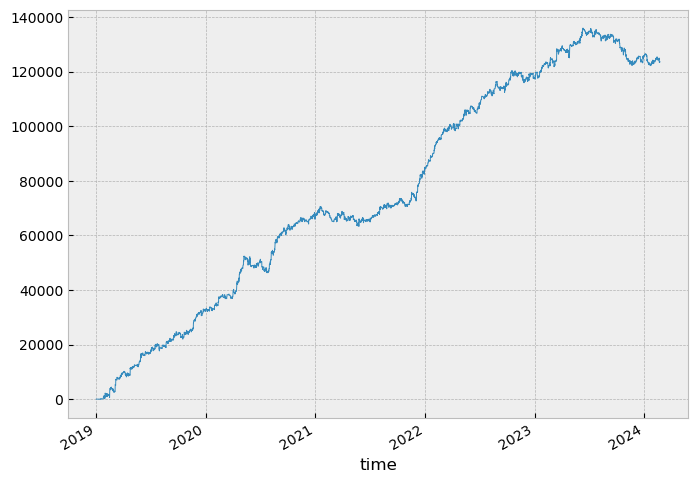

In [139]:
normalize_data[final_ls].cumsum().plot(legend=None)
plt.show()
normalize_data[final_ls].sum(axis=1).cumsum().plot(legend=None)

In [181]:
def add_costi(lista, valore_da_sottrarre):
  
  nuova_lista = []
  primo_valore_diverso_da_zero = False
  
  for numero in lista:
    if not primo_valore_diverso_da_zero and numero != 0:
      primo_valore_diverso_da_zero = True
      numero -= valore_da_sottrarre
    elif numero == 0:
      primo_valore_diverso_da_zero = False
    
    nuova_lista.append(numero)
  
  return nuova_lista


Lista originale: [0, 0, 0, 50, -5, 10, 0, 0, -7, 0, 19, 23, 45, 56, 0, 0, 0, 0, 0]
Lista modificata: [0, 0, 0, 45, -5, 10, 0, 0, -12, 0, 14, 23, 45, 56, 0, 0, 0, 0, 0]
